# Data Analysis

The notebook details the process of EDA and analysis of the merged datasets.

## Content (Visuals)
- heat map showing spearman(?) correlation
- bivariate Geographical map showing mh score and some impactful environmental feature at either the state or division
level, with indicators for states that have few rows in our cleaned dataset
- mental health scores for our city comparisons
- Maybe a pairplot(?) showing correlations between features but we need to decide which <10 features to include in that pairplot

In [8]:
# set up the environment
import numpy as np

# import modules
import map_module as map
import file_path as path

## Urban Centers with similar environmental features
visual will be multi subplots choropleth map that presenting their `mh_score` (aka Mental Illness Score)

In [3]:
# load the file paths
geo_data = path.geo_us_file
merged_data = path.merged_data_file

# merge geo data with the merged data, return a normalized dataframe
mh_score_df, _ = map.df_manipulation_for_bimap(
    geo_data,
    merged_data,
    "Longitude",
    other_features=["State", "Urban Center"],
    lefton="UC_Grouping",
    righton="UC_Grouping",
    mh_feature="MH_Score",
    percentile=np.linspace(0.33, 1, 3),
    color_list=["#ffb000", "#dc267f", "#648fff", "#785ef0"],
    env_color_01="c1_env",
    mh_col="MH_Score",
    mh_color_02="c2_mh",
)


In [4]:
# preview the data
print(type(mh_score_df))
mh_score_df.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry,MH_Score,Longitude,State,Urban Center,c1_env,c2_mh
0,"MULTIPOLYGON (((-158.01244 21.42219, -157.9915...",0.052083,0.000000,HI,Honolulu,2,2
1,"MULTIPOLYGON (((-120.46375 34.98933, -120.4411...",0.656250,0.427609,CA,Santa Maria,1,1


In [9]:
# create color list for ledgend
# define the percentile
percentile=np.linspace(0.2, 1, 5)

c_lst = map.mono_mikhailsirenko_colorscale(
    percentile=percentile, color_list=["#0000FF", "#FF0000"]
)

In [10]:
# assign color to the data
color_df = map.mono_assign_color_cells(
    mh_score_df,
    mh_col="MH_Score",
    mh_color_02="mh_color",
    percentile=percentile,
)
color_df.sample(3)

,geometry,MH_Score,Longitude,State,Urban Center,c1_env,c2_mh,mh_color
175,"MULTIPOLYGON (((-85.61470 43.05564, -85.59044 ...",0.489583,0.824448,MI,Grand Rapids,0,1,2
118,"MULTIPOLYGON (((-90.32559 38.84594, -90.30228 ...",0.625000,0.771658,MO,St. Louis,0,1,1
115,"MULTIPOLYGON (((-86.27305 32.41323, -86.22872 ...",0.635417,0.817844,AL,Montgomery,0,1,1


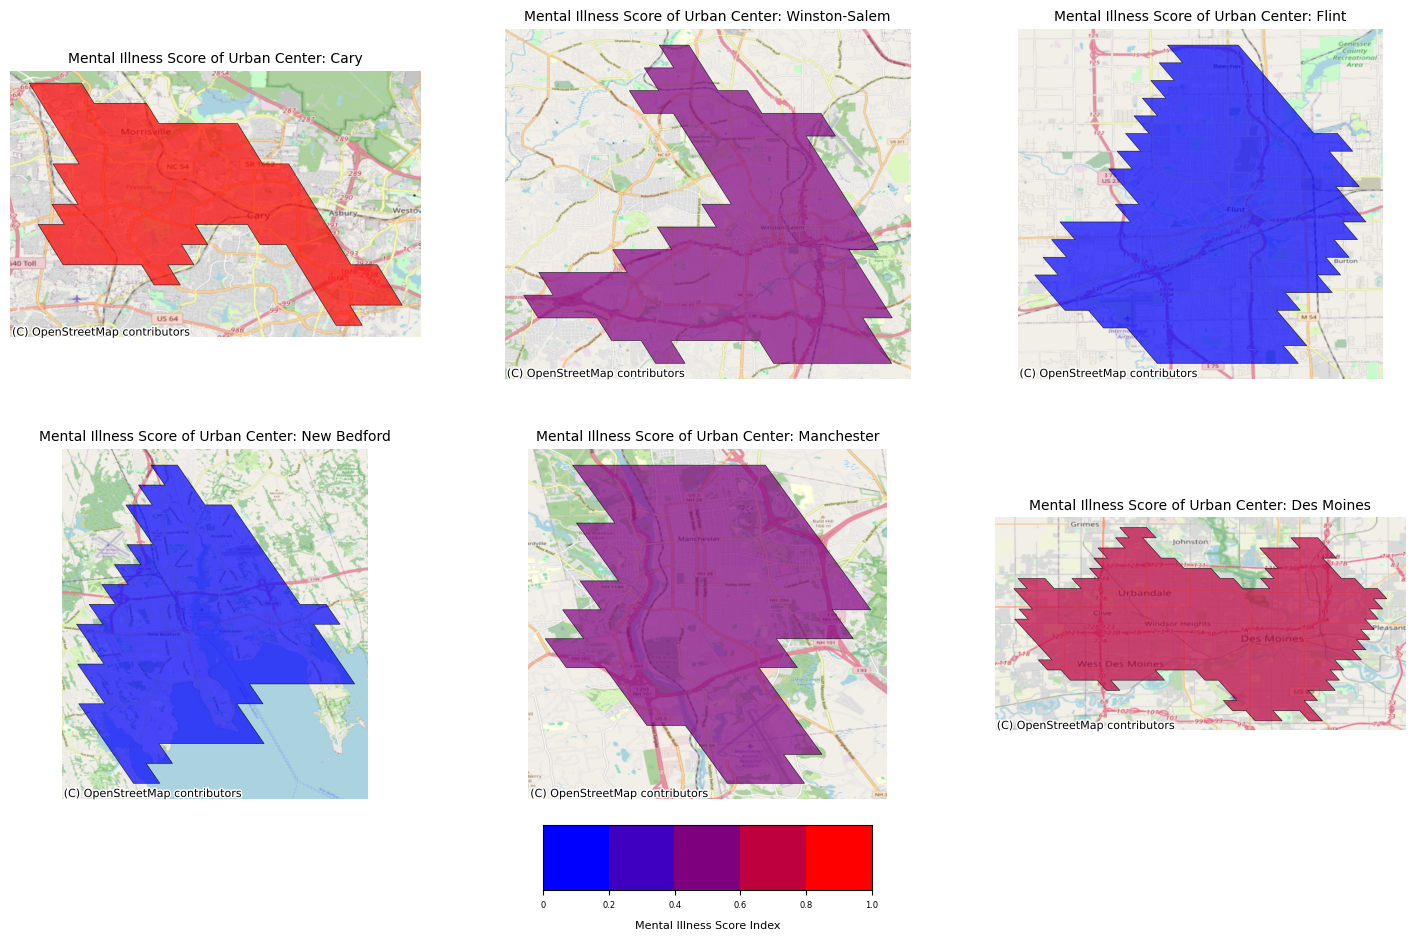

In [11]:
# define the urban center list, which included 6 urban centers
urban_center_lst = [
    "Cary",
    "Winston-Salem",
    "Flint",
    "New Bedford",
    "Manchester",
    "Des Moines",
]

# plot the map
map.one_function_monoMap(
    color_df,
    urban_center_lst,
    c_lst,
    fig_row=2,
    fig_col=3,
    fig_size=(18, 10),
    alpha=0.7,
    mh_color_02="mh_color",
    filter_col="Urban Center",
    edgecolor="black",
    linewidth=0.5,
    plot_title_fontsize=10,
    percentile=percentile,
    legend_position=[-1.1, -1, 0.8, 0.8],
    tick_fontsize=6,
    label_fontsize=8,
    legend_title="Mental Illness Score Index",
)

### Key Findings